### Loading the Libraries

In [1]:
import string
import numpy as np
import PIL.Image

from os import listdir
from pickle import dump, load

from numpy import array
from numpy import argmax

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [2]:
# Extract features from each photo in the directory
def extract_features(directory):
    
    # Loading the model
    model = VGG16()

    # Removing the last layer from the loaded model as we require only the features not the classification 
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    
    # Summarizing the model 
    print(model.summary())

    # Extracting features from each photo and storing it in a dictionary 
    feature_set = dict()

    for name in listdir(directory):

        # Defining the path of the image 
        file_name = directory + '/' + name
        
        # Loading an image and converting it into size 224 * 224
        image = load_img(file_name, target_size=(224, 224))
        
        # Converting the image pixels into a numpy array
        image = img_to_array(image)
        
        # Reshaping data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        
        # Preprocessing the images for the VGG model
        # The preprocess_input function is meant to adequate your image to the format the model requires.
        image = preprocess_input(image)

        # Getting features of an image
        feature = model.predict(image, verbose=0)
        
        # Getting the image name
        image_id = name.split('.')[0]

        # Storing the feature corresponding to the image in the dictionary
        feature_set[image_id] = feature
        
        # print('>%s' % name)
        
    return feature_set

In [3]:
# Defining the directory we are using
directory = '../input/flickr8k_dataset/Flicker8k_Dataset'

# Extracting features from all the images
feature_set= extract_features(directory)

print('Extracted Features: ', len(features))

# Dumping the features in a pickle file for further use
dump(features, open('features.pkl', 'wb'))

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___

In [4]:
listdir('../input')

['flickr8k_text', 'flickr8k_dataset', 'Flickr8k_text', 'Flickr8k_Dataset']

# 2. Preparing Text Data

In [5]:
# Loading the file containg all the descriptions into memory

def load_doc(file_name):
    # Opening the file as read only
    file = open(file_name, 'r')

    # Reading all text and storing it.
    captions = file.read()

    # Closing the file
    file.close()
    
    return captions


In [6]:
def image_to_caption_mapping(captions):
    
    # Dictionary to store the mapping of photo identifiers to captions
    caption_mapping = dict()
    
    # Iterating through each line of the captions
    for line in captions.split('\n'):
        
        # Splitting the lines by white space
        words = line.split()
        
        # Skipping the lines with length less than 2
        if len(line)<2:
            continue
            
        # The first word is the image_id and the rest are the part of the description of that image
        image_id, image_description = words[0], words[1:]
        
        # Retaining only the name of the image and removing the extension from it
        image_id = image_id.split('.')[0]
        
        # Image_descriptions contains comma separated words of the description, hence, converting it back to string
        image_description = ' '.join(image_description)
        
        # There are multiple descriptions per image, 
        # hence, corresponding to every image identifier in the dictionary, there is a list of description
        # if the list does not exist then we need to create it
        
        if image_id not in caption_mapping:
            caption_mapping[image_id] = list()
            
        # Now storing the descriptions in the mapping
        caption_mapping[image_id].append(image_description)
    
    return caption_mapping

In [7]:
def clean_captions(caption_mapping):
    
    # Preapring a translation table for removing all the punctuation
    table = str.maketrans('','', string.punctuation)
    
    # Traversing through the mapping we created
    for key, captions in caption_mapping.items():
        for i in range(len(captions)):
            description = captions[i]
            description = description.split()
            
            # Converting all the words to lower case
            description = [word.lower() for word in description]
            
            # Removing the punctuation using the translation table we made
            description = [word.translate(table) for word in description]
            
            # Removing the words with length =1
            description = [word for word in description if len(word)>1]
            
            # Removing all words with number in them
            description = [word for word in description if word.isalpha()]
            
            # Converting the description back to string and overwriting in the captions list
            captions[i] = ' '.join(description)


In [8]:

# Converting the loaded descriptions into a vocabulary of words
def desc_to_vocab(descriptions):
    
    # Build a list of all description strings
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    
    return all_desc

In [9]:

    # save descriptions to file, one description per line
def save_descriptions_to_file(descriptions, file_name):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(file_name, 'w')
    file.write(data)
    file.close()

In [10]:
file_name = '../input/flickr8k_text/Flickr8k.token.txt'

# Loading descriptions
document = load_doc(file_name)

# Parsing descriptions
descriptions = image_to_caption_mapping(document)
print('Loaded: %d ' % len(descriptions))

# Cleaning the descriptions
clean_descriptions(descriptions)

# Summarizing the vocabulary
vocabulary = desc_to_vocab(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# Saving to the file
save_descriptions_to_file(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


# 3. Developing Deep Learning Model

## A.) Loading the data

In [11]:
# Function for loading a file into memory and returning text from it
def load_file(file_name):
    file = open(file_name, 'r')
    text = file.read()
    file.close()
    return text

# Function for loading a pre-defined list of photo identifiers
def load_photo_ID(file_name):
    
    # Loading the file containing the list of photo identifier
    file = load_file(file_name)
    
    # Creating a list for storing the identifiers
    images = list()
    
    # Traversing the file one line at a time
    for line in file.split('\n'):
        if len(line) < 1:
            continue
        
        # Image name contains the extension as well but we need just the name
        ID = line.split('.')[0]
        
        # Adding it to the list of photos
        images.append(ID)
        
    # Returning the set of photos created
    return set(images)


# loading the cleaned descriptions that we created earlier
# we will only be loading the descriptions of the images that we will use for training
# hence we need to pass the set of train photos that the above function will be returning

def load_clean_descriptions(file_name, images):
    
    #loading the cleaned description file
    file = load_file(file_name)
    
    #creating a dictionary of descripitions for storing the photo to description mapping of train images
    captions = dict()
    
    #traversing the file line by line
    for line in file.split('\n'):
        # splitting the line at white spaces
        words = line.split()
        
        # the first word will be the image name and the rest will be the description of that particular image
        image_id, image_description = words[0], words[1:]
        
        # we want to load only those description which corresponds to the set of photos we provided as argument
        if image_id in images:
            #creating list of description if needed
            if image_id not in captions:
                captions[image_id] = list()
            
            
            desc = 'startseq ' + ' '.join(image_description) + ' endseq'
            captions[image_id].append(desc)
            
    return captions

# function to load the photo features created using the VGG16 model
def load_photo_features(file_name, images):
    
    #this will load the entire features
    all_features = load(open(file_name, 'rb'))
    
    #we are interested in loading the features of the required photos only
    feature_set= {k: all_features[k] for k in images}
    
    return feature_set

In [12]:
file_name = '../input/flickr8k_text/Flickr_8k.trainImages.txt'

train = load_photo_ID(file_name)
print('Dataset: ',len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))

train_features = load_photo_features('features.pkl', train)
print('Photos: train=', len(train_features))

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000


In [13]:
# convert a dictionary of clean descriptions to a list of descriptions
def desc_to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Given the descriptions, fit a tokenizer

# TOKENIZER CLASS:
def create_tokenizer(descriptions):
    lines = desc_to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [14]:
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)


Vocabulary Size:  7579


In [15]:
#calculated the length of description with most words
def max_length_max_words(descriptions):
    lines = desc_to_lines(descriptions)
    return max(len(d.split()) for d in lines)

## B.) Defining the Model

In [16]:
def generate_data(descriptions, images, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            photo = images[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, photo)
            yield [[input_image, input_sequence], output_word]

            
#sequence_creator() function creates a batch worth of data for a single photo rather than an entire dataset. 

def sequence_creator(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        sequence = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(sequence)):
            # split into input and output pair
            in_seq, out_seq = sequence[:i], sequence[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [18]:
from keras.utils import plot_model
# define the captioning model

def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    feature_set_1 = Dropout(0.5)(inputs1)
    feature_set_2 = Dense(256, activation='relu')(feature_set_1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    sequence_1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    sequence_2 = Dropout(0.5)(sequence_1)
    se3 = LSTM(256)(sequence_2)

    # decoder model
    decoder_1 = add([feature_set_2, se3])
    decoder_2 = Dense(256, activation='relu')(decoder_1)
    outputs = Dense(vocab_size, activation='softmax')(decoder_2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [19]:
file_name = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_ID(file_name)
print('Dataset : ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions : train=', len(train_descriptions))
train_features = load_photo_features('features.pkl', train)
print('Photos : train=', len(train_features))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size :', vocab_size)
max_length = max_length_max_words(train_descriptions)
print('Description Length : ', max_length)

model = define_model(vocab_size, max_length)
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    generator = generate_data(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  34
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
_____________________________________________________________________________________

In [20]:
listdir()

['model_0.h5',
 'model_19.h5',
 'model_5.h5',
 'model_11.h5',
 'model_1.h5',
 'model_16.h5',
 'model_15.h5',
 'model_10.h5',
 'model_6.h5',
 'model_7.h5',
 'model_3.h5',
 'model.png',
 'features.pkl',
 'model_9.h5',
 'model_2.h5',
 'model_17.h5',
 'model_12.h5',
 '__notebook_source__.ipynb',
 'model_14.h5',
 'model_8.h5',
 'descriptions.txt',
 'model_4.h5',
 'model_13.h5',
 'model_18.h5']

# 4. Evaluate the model

In [21]:
#this function maps an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#The function below generates a textual description given a trained model, 

def generate_desc(model, tokenizer, photo, max_length):
    #start tge generation process
    in_text = 'startseq'
    #iterating over the max_length since the maximum length of the description can be that only
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #padding the input
        sequence = pad_sequences([sequence], maxlen=max_length)
        #the predict function will return probability
        prob = model.predict([photo,sequence], verbose=0)
        #converting the probability to integer
        prob = argmax(prob)
        #map integer to word
        word = word_for_id(prob, tokenizer)
        if word is None:
            break
        #appending as input
        in_text += ' ' + word
        #break if end is predicted
        if word == 'endseq':
            break
    return in_text

#the below function evaluates the skill of the model
def model_evaluate(model, descriptions, images, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, images[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())

    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: ', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: ', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: ', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
def max_length(descriptions):
    lines = desc_to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [22]:
file_name = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_ID(file_name)
print('Dataset : ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions : train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size : ', vocab_size)
max_length = max_length_max_words(train_descriptions)
print('Description Length : ,', max_length)

file_name = '../input/flickr8k_text/Flickr_8k.testImages.txt'
test = load_photo_ID(file_name)
print('Dataset : ', len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions : test=', len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=', len(test_features))

file_name = 'model_12.h5'
model = load_model(file_name)
model_evaluate(model, test_descriptions, test_features, tokenizer, max_length)



Dataset:  6000
Descriptions: train= 6000
Vocabulary Size:  7579
Description Length: , 34
Dataset:  1000
Descriptions: test= 1000
Photos: test= 1000
BLEU-1:  0.5164375142847769
BLEU-2:  0.26875306917454805
BLEU-3:  0.18007946052272816
BLEU-4:  0.07873526305153902


# 5. Generate new descriptions

In [24]:
#Generating new descriptions to given images
file_name = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_ID(file_name)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset:  6000
Descriptions: train= 6000


In [25]:
def extract_features(file_name):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    #loading image
    image = load_img(file_name, target_size=(224, 224))
    image = img_to_array(image)
    #reshaping image
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #image preprocessing
    image = preprocess_input(image)
    features = model.predict(image, verbose=0)
    return features

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


#generate new descriptions
def generate_desc(model, tokenizer, image, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34

In [28]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

startseq man is standing on the edge of the water endseq


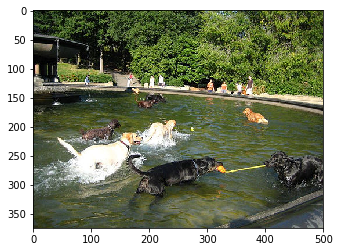

In [30]:
model = load_model('model_19.h5')
path = '../input/me-yes.jpg'
photo = extract_features(path)

description = generate_desc(model, tokenizer, photo, max_length)
print(description)
img=image.load_img('../input/me-yes.jpg')
img=image.img_to_array(img)
plt.imshow((img/255)*1)